<left><img width=25% src="img/cornell_tech2.svg"></left>

# Lecture 17: Density Estimation

### Applied Machine Learning

__Volodymyr Kuleshov__<br>Cornell Tech

# Part 1: Unsupervised Probabilistic Models

Density estimation is the problem of estimating a probability distribution from data.

As a first step, we will introduce probabilistic models for unsupervised learning.

# Review: Unsupervised Learning

We have a dataset *without* labels. Our goal is to learn something interesting about the structure of the data:
* Clusters hidden in the dataset.
* Outliers: particularly unusual and/or interesting datapoints.
* Useful signal hidden in noise, e.g. human speech over a noisy phone.

# Components of an Unsupervised Learning Problem

At a high level, an unsupervised machine learning problem has the following structure:

$$ \underbrace{\text{Dataset}}_\text{Attributes} + \underbrace{\text{Learning Algorithm}}_\text{Model Class + Objective + Optimizer } \to \text{Unsupervised Model} $$

The unsupervised model describes interesting structure in the data. For instance, it can identify interesting hidden clusters.

# Review: Data Distribution

We will assume that the dataset is sampled from a probability distribution $P_\text{data}$, which we will call the *data distribution*. We will denote this as
$$x \sim P_\text{data}.$$

The dataset $\mathcal{D} = \{x^{(i)} \mid i = 1,2,...,n\}$ consists of *independent and identicaly distributed* (IID) samples from $P_\text{data}$.

# Review: Unsupervised Models

We'll say that a model is a function
$$ f : \mathcal{X} \to \mathcal{S} $$
that maps inputs $x \in \mathcal{X}$ to some notion of structure $s \in \mathcal{S}$.

Structure can have many definitions (clusters, low-dimensional representations, etc.), and we will see many examples.

Often, models have *parameters* $\theta \in \Theta$ living in a set $\Theta$. We will then write the model as
$$ f_\theta : \mathcal{X} \to \mathcal{S} $$
to denote that it's parametrized by $\theta$.

# Unsupervised Probabilistic Models

An unsupervised probabilistic model is a probability distribution
$$P(x) : \mathcal{X} \to [0,1].$$
This model can approximate the data distribution $P_\text{data}$.

Probabilistic models also have *parameters* $\theta \in \Theta$, which we denote as
$$P_\theta(x) : \mathcal{X} \to [0,1].$$

# Why Use Probabilistic Models?

There are many tasks that we can solve with a good model $P_\theta$.
1. Generation: sample new objects from $P_\theta$, such as images.
2. Representation learning: find interesting structure in $P_\text{data}$
3. Density estimation: approximate $P_\theta \approx P_\text{data}$ and use it to solve any downstream task (generation, clustering, outlier detection, etc.).

We are going to be interested in the latter.

# Kullback-Leibler Divergence

In order to approximate $P_\text{data}$ with $P_\theta$, we need a measure of distance between distributions.

A standard measure of similarity between distributions is the *Kullback-Leibler (KL) divergence* between two distributions $p$ and $q$, defined as
$$
D(p \| q) = \sum_{{\bf x}} p({\bf x}) \log \frac{p({\bf x})}{q({\bf x})}.
$$

#### Observations:
* $D(p \, \| \, q) \geq 0$ for all $p, q$, with equality if and only if $p= q$. Proof:
\begin{align*}
	D(p \| q) = \mathbb{E}_{x\sim p}{-\log \frac{q({\bf x})}{p({\bf x})}} & \geq -\log \left( \mathbb{E}_{x\sim p} {\frac{q({\bf x})}{p({\bf x})}} \right) \\ = &
	-\log \left( \sum_{{\bf x}} p({\bf x}) \frac{q({\bf x})}{p({\bf x})} \right)
	=
	0
\end{align*}
where in the first line we used [Jensen's inequality](https://en.wikipedia.org/wiki/Jensen%27s_inequality)

* The KL-divergence is *asymmetric*, i.e., $D(p \| q) \neq D(q \| p)$

# Learning Models Using KL Divergence

We may now learn a probabilistic model $P_\theta(x)$ that approximates $P_\text{data}(x)$ via the KL divergence:
\begin{align*}
D(P_{\textrm{data}} \mid \mid {P_\theta}) & = \mathbb{E}_{x \sim P_{\textrm{data}}}{\log\left(
\frac{P_{\textrm{data}}(x)}{P_\theta(x)}
\right)} \\ & = \sum_{{x}} P_{\textrm{data}}({x}) \log \frac{P_{\textrm{data}}({x})}{P_\theta(x)}
\end{align*}

Note that $D(P_{\textrm{data}} \mid \mid {P_\theta})=0$ iff the two distributions are the same.

# From KL Divergence to Log Likelihood

$
\newcommand{\x}{x}
\newcommand{\ex}[2]{\mathbb{E}_{#1 \sim #2}}
\newcommand{\en}[2]{D(#1 \mid \mid #2)}
$

We can learn $P_\theta$ that approximates $P_\text{data}$ by minimizing $D(P_{\textrm{data}} \mid \mid {P_\theta})$. This objective further simplifies as:
\begin{eqnarray*}
\en{P_{\textrm{data}}}{P_\theta} &=& \ex{\x}{P_{\textrm{data}}}{\log\left(
\frac{P_{\textrm{data}}(\x)}{P_\theta(\x)}
\right)} \\
&=& 
%-\bH(P_{\textrm{data}}) 
\ex{\x}{P_{\textrm{data}}}{\log P_{\textrm{data}}(\x)}
- \ex{\x}{P_{\textrm{data}}}{\log P_\theta(\x)}
\end{eqnarray*}


The first term does not depend on $P_\theta$: minimizing KL divergence is equivalent to maximizing the expected log-likelihood.

\begin{align*}
\arg\min_{P_\theta} \en{P_{\textrm{data}}}{P_\theta} & = \arg\min_{P_\theta} - \ex{\x}{P_{\textrm{data}}}{\log P_\theta(\x)} \\ & = \arg\max_{P_\theta} \ex{\x}{P_{\textrm{data}}}{\log P_\theta(\x)}
\end{align*}

* This asks that $P_\theta$ assign high probability to instances sampled from $P_{\textrm{data}}$, so as to reflect the true distribution.

* Because of $\log$, samples $\x$ where $P_\theta(\x) \approx 0$ weigh heavily in the objective.

Problem: In general we do not know $P_{\textrm{data}}$, hence expected value is intractable.

# Maximum Likelihood Estimation

$
\newcommand{\exd}[2]{\mathbb{E}_{#1 \sim #2}}
\newcommand{\cd}{\mathcal{D}}
$

Applying, Monte Carlo estimation, we may approximate the expected log-likelihood
$$
\ex{\x}{P_{\textrm{data}}}{\log P_\theta(\x)}
$$
with the *empirical log-likelihood*:
$$
\exd{\cd}{P_\theta(\x)} = \frac{1}{|\cd|}\sum_{\x\in \cd} \log P_\theta(\x)
$$

Maximum likelihood learning is then:
$$
\max_{P_\theta} \hspace{2mm} \frac{1}{|\cd|}\sum_{\x\in \cd} \log P_\theta(\x).
$$
<!-- Equivalently, we maximize probability of the data under model $P_\theta((x^{(1)}, y^{(1)}), \cdots, (x^{(n)}, y^{(n)})) = \prod_{\x\in \cd} P_\theta(\x)$ -->

# Example: Flipping a Random Coin

How should we choose $P_\theta(x)$ if 3 out of 5 coin tosses are heads? Let's apply maximum likelihood learning.

* Our model is $P_\theta(x=H)=\theta$ and $P_\theta(x=T)=1-\theta$
* Our data is: $\cd=\{H,H,T,H,T\}$ 
* The likelihood of the data is $\prod_{i} P_\theta(x_i)=\theta \cdot \theta \cdot (1-\theta) \cdot \theta \cdot (1-\theta)$.

We optimize for $\theta$ which makes $\cd$ most likely. What is the solution in this case?

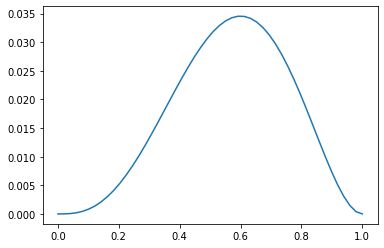

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

# our dataset is {H, H, T, H, T}; if theta = P(x=H), we get:
coin_likelihood = lambda theta: theta*theta*(1-theta)*theta*(1-theta)

theta_vals = np.linspace(0,1)
plt.plot(theta_vals, coin_likelihood(theta_vals))

<left><img width=25% src="img/cornell_tech2.svg"></left>
# Part 2: Kernel Density Estimation

Next, let's look at a first example of probabilistic models and how they are used to perform density estimation.

# Review: Data Distribution

We will assume that the dataset is sampled from a probability distribution $\mathbb{P}$, which we will call the *data distribution*. We will denote this as
$$x \sim P_\text{data}.$$

The dataset $\mathcal{D} = \{x^{(i)} \mid i = 1,2,...,n\}$ consists of *independent and identicaly distributed* (IID) samples from $P_\text{data}$.

# Review: Unsupervised Probabilistic Models

An unsupervised probabilistic model is a probability distribution
$$P_\theta(x) : \mathcal{X} \to [0,1].$$
This model can approximate the data distribution $P_\text{data}$. It may have parameters $\theta$.

# Density Estimation

The problem of density estimation is to approximate the data distribution $P_\text{data}$ with the model $P$.
$$ P \approx P_\text{data}. $$

It's also a general learning task. We can solve many downstream tasks using a good model $P$:
* Outlier and novelty detection
* Generating new samples $x$
* Visualizing and understanding the structure of $P_\text{data}$

# Histogram Density Estimation

Perhaps the simplest approach to density estimation is by forming a histogram.

A histogram partitions the input space $x$ into a $d$-dimensional grid and counts the number of points in each cell.

This is best illustrated by an example. 

Let's start by creating a simple 1D dataset coming from a mixture of two Gaussians:

$$P_\text{data}(x) = 0.3 \cdot \mathcal{N}(x ; \mu=0, \sigma=1) + 0.7 \cdot \mathcal{N}(x ; \mu=5, \sigma=1)$$

In [23]:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html
import numpy as np
np.random.seed(1)

N = 20 # number of points
# concat samples from two Gaussians:
X = np.concatenate((
    np.random.normal(0, 1, int(0.3 * N)), 
    np.random.normal(5, 1, int(0.7 * N))
))[:, np.newaxis]
bins = np.linspace(-5, 10, 10) # locations of the bins

# print out X
print(X.flatten())

[ 1.62434536 -0.61175641 -0.52817175 -1.07296862  0.86540763 -2.3015387
  6.74481176  4.2387931   5.3190391   4.75062962  6.46210794  2.93985929
  4.6775828   4.61594565  6.13376944  3.90010873  4.82757179  4.12214158
  5.04221375  5.58281521]


We can now estimate the density using a histogram.

(-0.02, 0.25)

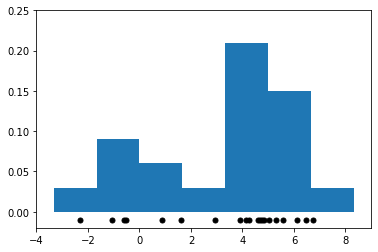

In [41]:
import matplotlib.pyplot as plt

plt.hist(X[:, 0], bins=bins, density=True) # plot the histogram
plt.plot(X[:, 0], np.full(X.shape[0], -0.01), '.k', markersize=10) # plot the points in X
plt.xlim(-4, 9)
plt.ylim(-0.02, 0.25)

# Limitations of Histograms

Histogram-based methods have a number of shortcomings.
* The number of grid cells increases exponentially with dimension $d$.
* The histogram is not "smooth".
* The shape of the histogram depends on the bin positions.

We will now try to address the last two limitations.

Let's also visualize what we mean when we say that shape of the histogram depends on the histogram bins.

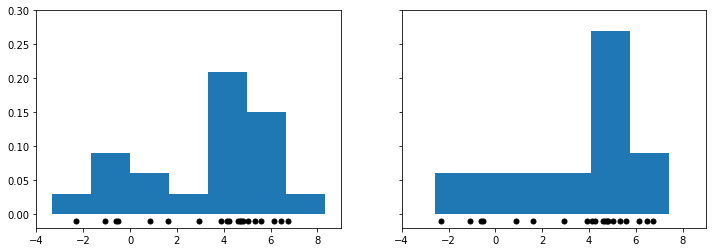

In [38]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,4))
ax[0].hist(X[:, 0], bins=bins, density=True) # plot the histogram
ax[1].hist(X[:, 0], bins=bins+0.75, density=True) # plot the histogram with bin centers shifted by 0.75
for axi in ax.ravel():
    axi.plot(X[:, 0], np.full(X.shape[0], -0.01), '.k', markersize=10) # plot the points in X
    axi.set_xlim(-4, 9)
    axi.set_ylim(-0.02, 0.3)

# Kernel Density Estimation: Idea

Kernel density estimation (KDE) is a different approach to histogram estimation.
* A histogram has $b$ bins of width $\delta$ at fixed positions.
* KDE effectively places a bin of with $\delta$ at each $x \in \mathcal{X}$.
* To obtain $P(x)$, we count the % of points that fall in the bin centered at $x$.

# Tophat Kernel Density Estimation

The simplest form of this strategy (Tophat KDE) assumes a model of the form
$$P_\delta(x) = \frac{N(x; \delta)}{n},$$
where
$$ N(x; \delta) = |\{x^{(i)} : ||x^{(i)} - x || \leq \delta/2\}|, $$
is the number of points that are within a bin of with $\delta$ centered at $x$.

This is best understood via a picture.

(-0.02, 0.32)

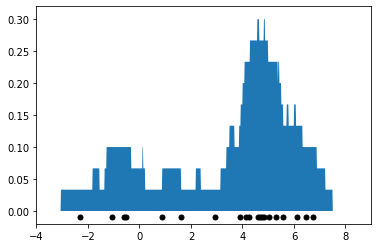

In [47]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel='tophat', bandwidth=0.75).fit(X) # fit a KDE model
x_ticks = np.linspace(-5, 10, 1000)[:, np.newaxis] # choose 1000 points on x-axis
log_density = kde.score_samples(x_ticks) # compute density at 1000 points

plt.fill(x_ticks[:, 0], np.exp(log_density)) # plot the density estimate
plt.plot(X[:, 0], np.full(X.shape[0], -0.01), '.k', markersize=10) # plot the points in X
plt.xlim(-4, 9)
plt.ylim(-0.02, 0.32)

The above algorithm still has the problem of producing a density estimate that is not smooth.

We are going to resolve this by replacing histogram counts with weighted averages.

# Review: Kernels

A *kernel function* $K : \mathcal{X} \times \mathcal{X} \to [0, \infty]$ maps pairs of vectors $x, z \in \mathcal{X}$ to a real-valued score $K(x,z)$.

* A kernel represents the similarity between $x$ and $z$.
* It also often encodes the dot product between $x$ and $z$ in some high-dimensional feature space

We will use the first interpretation here.

# Kernel Density Estimation

A kernelized density model $P$ takes the form:
$$P(x) \propto \sum_{i=1}^n K(x, x^{(i)}).$$
This can be interpreted in different ways:
* We count the number of points "near" $x$, but each $x^{(i)}$ has a weight $K(x, x^{(i)})$ that depends on similarity between $x, x^{(i)}$.
* We place a "micro-density" $K(x, x^{(i)})$ at each $x^{(i)}$; the final density $P(x)$ is their sum.

# Types of Kernels

We have seen several types of kernels in the context of support vector machines.

There are additional kernels that are popular for density estimation.

The following kernels are available in `scikit-learn`.
* Gaussian kernel $K(x,z; \delta) \propto \exp(-||x-z||^2/2\delta^2)$
* Tophat kernel $K(x,z; \delta) = 1 \text{ if } ||x-z|| \leq \delta/2$ else $0$.
* Epanechnikov kernel $K(x,z; \delta) \propto 1 - ||x-z||^2/\delta^2$
* Exponential kernel $K(x,z; \delta) \propto \exp(-||x-z||/\delta)$
* Linear kernel $K(x,z; \delta) \propto (1 - ||x-z||/\delta)^+$

It's easier to understand these kernels by looking at a figure.

Text(0.5, 1.0, 'Available Kernels')

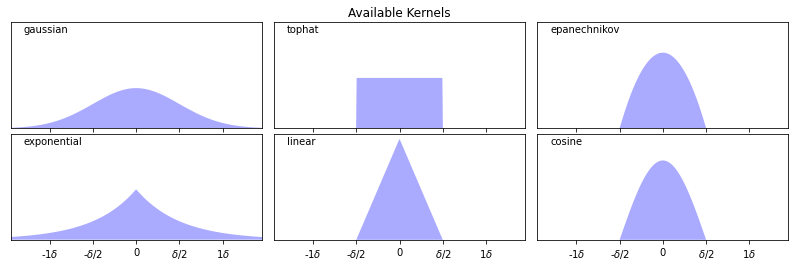

In [81]:
# https://scikit-learn.org/stable/auto_examples/neighbors/plot_kde_1d.html
X_plot = np.linspace(-6, 6, 1000)[:, None]
X_src = np.zeros((1, 1))

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(12,4))
fig.subplots_adjust(left=0.05, right=0.95, hspace=0.05, wspace=0.05)

def format_func(x, loc):
    if x == 0:
        return '0'
    elif x == 1:
        return '$\delta/2$'
    elif x == -1:
        return '-$\delta/2$'
    else:
        return '%i$\delta$' % (int(x/2))

for i, kernel in enumerate(['gaussian', 'tophat', 'epanechnikov',
                            'exponential', 'linear', 'cosine']):
    axi = ax.ravel()[i]
    log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(X_plot)
    axi.fill(X_plot[:, 0], np.exp(log_dens), '-k', fc='#AAAAFF')
    axi.text(-2.6, 0.95, kernel)

    axi.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    axi.xaxis.set_major_locator(plt.MultipleLocator(1))
    axi.yaxis.set_major_locator(plt.NullLocator())

    axi.set_ylim(0, 1.05)
    axi.set_xlim(-2.9, 2.9)

ax[0, 1].set_title('Available Kernels')


# Kernel Density Estimation: Example

Let's look at an example in the context of the 1D points we have seen earlier.

We will fit a model of the form
$$P(x) = \sum_{i=1}^n K(x, x^{(i)})$$
with a Gaussian kernel $K(x,z; \delta) \propto \exp(-||x-z||^2/2\delta^2)$.

(-0.02, 0.32)

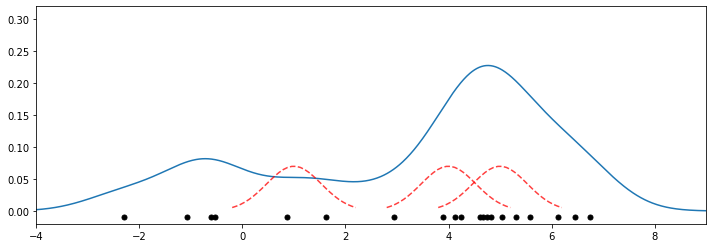

In [77]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(X) # fit a KDE model
x_ticks = np.linspace(-5, 10, 1000)[:, np.newaxis] # choose 1000 points on x-axis
log_density = kde.score_samples(x_ticks) # compute density at 1000 points
gaussian_kernel = lambda z : lambda x: np.exp(-np.abs(x-z)**2/(0.75**2)) # gaussian kernel
kernel_linspace = lambda x : np.linspace(x-1.2,x+1.2,30)

plt.figure(figsize=(12,4))
plt.plot(x_tick s[:, 0], np.exp(log_density)) # plot the density estimate
plt.plot(X[:, 0], np.full(X.shape[0], -0.01), '.k', markersize=10) # plot the points in X
plt.plot(kernel_linspace(4), 0.07*gaussian_kernel(4)(kernel_linspace(4)), '--', color='r', alpha=0.75)
plt.plot(kernel_linspace(5), 0.07*gaussian_kernel(5)(kernel_linspace(5)), '--', color='r', alpha=0.75)
plt.plot(kernel_linspace(1), 0.07*gaussian_kernel(1)(kernel_linspace(1)), '--', color='r', alpha=0.75)
plt.xlim(-4, 9)
plt.ylim(-0.02, 0.32)

# KDE in Higher Dimensions

In priciple, kernel density estimation also works in higher dimensions.

However, the number of datapoints needed for a good fit incrases expoentially with the dimension, which limits the applications of this model in high dimensions.

# Choosing Hyperparameters

Each kernel has a notion of "bandwidth" $\delta$. This is a hyperparameter that controls the "smoothness" of the fit.
* We can choose it using inspection or heuristics like we did for $K$ in $K$-Means.
* Because we have a probabilistic model, we can also estimate likelihood on a holdout dataset (more on this later!)

Let's illustrate how the bandwidth affects smoothness via an example.

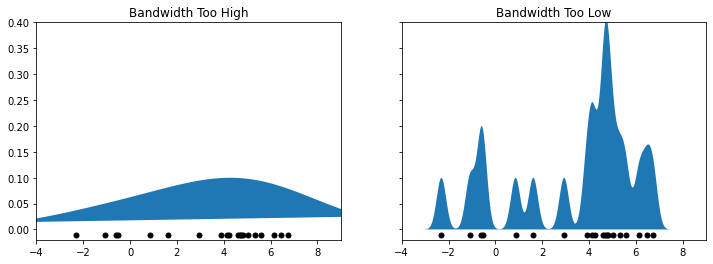

In [91]:
from sklearn.neighbors import KernelDensity

kde1 = KernelDensity(kernel='gaussian', bandwidth=3).fit(X) # fit a KDE model
kde2 = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(X) # fit a KDE model

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12,4))
ax[0].fill(x_ticks[:, 0], np.exp(kde1.score_samples(x_ticks))) # plot the density estimate
ax[1].fill(x_ticks[:, 0], np.exp(kde2.score_samples(x_ticks))) # plot the density estimate
ax[0].set_title('Bandwidth Too High')
ax[1].set_title('Bandwidth Too Low')

for axi in ax.ravel():
    axi.plot(X[:, 0], np.full(X.shape[0], -0.01), '.k', markersize=10) # plot the points in X
    axi.set_xlim(-4, 9)
    axi.set_ylim(-0.02, 0.4)

# Algorithm: Kernel Density Estimation

* __Type__: Unsupervised learning (density estimation).
* __Model family__: Non-parametric. Sum of $n$ kernels.
* __Objective function__: Log-likelihood to choose optimal bandwidth.
* __Optimizer__: Grid search.

# Pros and Cons of KDE

Pros:
* Can approximate any data distribution arbtrarily well.

Cons:
* Need to store entire dataset to make queries, which is computationally prohibitive.
* Number of data needed scale exponentially with dimension ("curse of dimensionality").

<left><img width=25% src="img/cornell_tech2.svg"></left>
# Part 3: Latent Variable Models

Probabilistic models we have seen earlier often need to approximate complex distributions.

In order to make our models more expressive, we introduce additional structure in the form of latent variables.

# Review: Probabilistic Models

An unsupervised probabilistic model is a probability distribution
$$P(x) : \mathcal{X} \to [0,1].$$
This model can approximate the data distribution $P_\text{data}$.

Probabilistic models also have *parameters* $\theta \in \Theta$, which we denote as
$$P_\theta(x) : \mathcal{X} \to [0,1].$$

# Review: Maximum Likelihood

In maximum likelihood learning, we maximize the *empirical log-likelihood*
$$
\max_{P_\theta} \hspace{2mm} \frac{1}{|\cd|}\sum_{\x\in \cd} \log P_\theta(\x),
$$
where $\mathcal{D} = \{x^{(i)} \mid i = 1,2,...,n\}$ is a dataset of *independent and identicaly distributed* (IID) samples from $P_\text{data}$.

# Latent Variable Models: Motivation

Consider the following dataset of human faces.
<center><img width=30% src="img/celebA.png"></center>

* It contains variability due to gender, eye color, hair color, pose, etc.
* However, unless these images are annotated, these factors of variation are not explicitly available (latent).

__Idea__: Explicitly model these factors using latent variables $z$ 

# Latent Variable Models: Definition

An latent-variable model is a probability distribution
$$P_\theta(x, z) : \mathcal{X} \times \mathcal{Z} \to [0,1]$$

containing two sets of variables:
* Observed $x$ that represent the high-dimensional object we are trying to model.
* Latent $z$ that are not in the training set, but can encode hidden structure in the data.

This model defines a $P_\theta(x) = \sum_{z \in \mathcal{Z}} P_\theta(x,z)$ that can approximate the data distribution $P_\text{data}(x)$.

# Latent Variable Models: Example

Consider the following example of latent variables
<center><img width=50% src="img/cartoonLVmodel.png"></center>

Only shaded variables $x$ are observed in the data (pixel values).
Latent variables $z$ correspond to high level features
* If $z$ is chosen properly, $\Pr(x| z)$ is much simpler than $\Pr(x)$
* We can identify features via $\Pr(z \mid x)$, e.g., $\Pr(\text{eye color} = \text{blue} | \x)$

# Mixtures of Gaussians

A mixture of Gaussians is a probability distribution $P(x,z)$ that factorizes into two components:
<center><img width=50% src="img/mogdensity_v3.png"></center>

* $P_\theta(z)$ is a [categorical](https://en.wikipedia.org/wiki/Categorical_distribution) distribution, and $P_\theta(z=k) = \phi_k$.
* $P_\theta(x\mid z=k)$ is a [multivariate Gaussian](https://en.wikipedia.org/wiki/Multivariate_normal_distribution) $\mathcal{N}(x; \mu_k, \Sigma_k)$ with mean and covariance $\mu_k, \Sigma_k$.

Thus, $P_\theta(x,z)$ is a mixture of $K$ Gaussians:
$$P_\theta(x,z) = \sum_{k=1}^K P_\theta(z=k) P_\theta(x|z=k) = \sum_{k=1}^K \phi_k \mathcal{N}(x; \mu_k, \Sigma_k)$$

Mixtures of Gaussians fit more complex distributions than one Gaussian.


Raw data | Single Gaussian | Mixture of Gaussians
--|--|---
<img width=90% src="img/oldfaithful_v2.png"> | <img width=90% src="img/oldfSingle_v2.png"> | <img width=90% src="img/oldfMOG_v2.png">

# Representational Power of LVMs

An important reason for using LVMs is that they are more expressive models.

<center><img width=50% src="img/mogdensity1d_v2.png"></center>

# Feature Representations from LVMs

Given $P_\theta(x,z)$ we can compute $P_\theta(z|x)$ to find useful latent representations.

<center><img width=70% src="img/dcgan_feats.png"></center>

Latent variables are also useful to identify clusters in the data.

<center><img width=50% src="img/aae_dim_reduc_2.png"></center>

# Learning Latent Variable Models

We can learn latent variable models using maximum likelihood:
$$
\sum_{\x\in \cd} \log \Pr(\x ; \theta)  = \sum_{\x\in \cd} \log \sum_{z \in \mathcal{Z}}\Pr(\x, z; \theta)
$$

However, optimizing this objective is almost always intractable.
* Consider a latent variable $z \in \{0,1\}^{30}$, of thirty binary dimensions.
* We need to sum over $2^{30} \approx$ 1B possible values that $z$ can take.
* For continuous variables we may need to solve an intractable integral $\int P(x,z) dz$.

# Approximate Inference in LVMs

In practice, we need to compute the likelihood objective (and its gradients) *approximately*.
* This is called approximate inference. We will see examples soon.
* The alternating algorithm for K-Means was a first simple example.

# Summary of LVMs

Latent-variable models are an important class of machine learning models.
* They can represent complex probability distributions
* They can find unsupervised feature representations

They also have drawbacks:
* Learning these models is computationally intractable and requires approximate algorithms
* Computing $P(z|x)$ to obtain latent features is also often intractable.